In this notebook, we apply GMM-MI to estimate the mutual information between each latent and density in each radial bin for the interpretable variational autoencoder presented in [Lucie-Smith et al. (2022)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.105.103533). We are essentially reproducing the central panel of Fig. 4. 

### Import packages

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder

### Load the data

In [16]:
truth = np.load("./halo_data/true_log_rho_per_radial_bin_sim11_testset.npy")
epoch = 27
lmean, lstd = np.load(f"./halo_data/latent_mean_11_testset_epoch_{epoch}.npy"), np.load(f"halo_data/latent_std_11_testset_epoch_{epoch}.npy")

In [17]:
radial_bins = truth.shape[0]
latents = lmean.shape[1]

### Calculate MI for all latents and radial bins

In [18]:
# parameters for the deep learning applications, notebooks 9-11
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-15)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=5,
                                                       n_folds=3)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e5)

In [19]:
results_file = f'./results/halo_MI.npy'

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    all_MI_estimates = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((radial_bins, latents, 2))
   
    for radial_bin in range(radial_bins):
        for latent in range(latents):
            samples = np.random.default_rng(42).normal(lmean[:, latent], lstd[:, latent], len(lmean[:, latent]))
            X = np.stack((samples, truth[radial_bin]), axis=0).T
            
            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params,
                                      mi_dist_params=mi_dist_params)
            MI_mean, MI_std = mi_estimator.fit(X)    
                        
            # store results
            all_MI_estimates[radial_bin, latent, 0] = MI_mean
            all_MI_estimates[radial_bin, latent, 1] = MI_std

            np.save(results_file, all_MI_estimates)

Not running this cell, since results file already exists. Loading pre-computed results...


### Plot results, overlapping the KDE results

In [20]:
# pre-calculated KDE results
KDE_02 = np.load('./halo_data/mi_truth_latents_epoch_27_bw_0.2.npy')[0].T
KDE_03 = np.load('./halo_data/mi_truth_latents_epoch_27_bw_0.3.npy')[0].T
KDE_01 = np.load('./halo_data/mi_truth_latents_epoch_27_bw_0.1.npy')[0].T

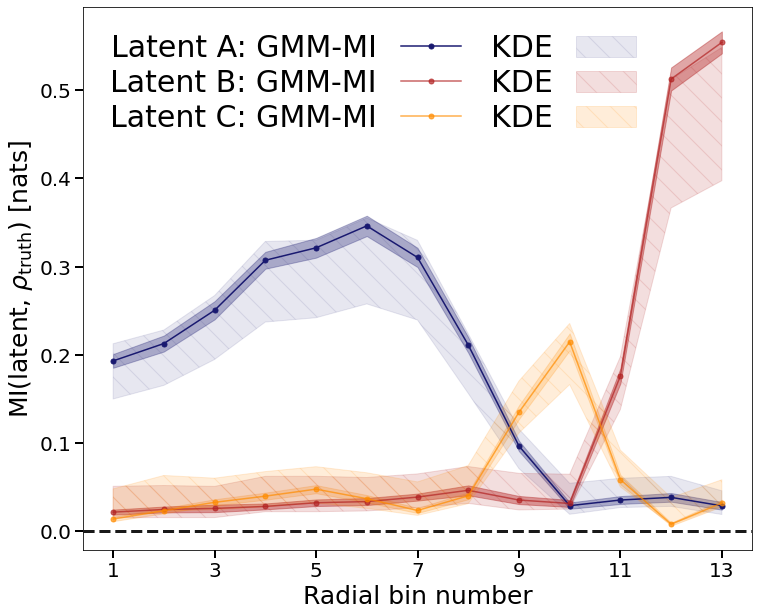

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

MI_radial_mean = all_MI_estimates[:, 0, 0]
MI_radial_std = all_MI_estimates[:, 0, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='midnightblue', marker='o', 
        markersize=5, alpha=1, label='Latent A: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std, 
                MI_radial_mean+MI_radial_std, color='midnightblue', alpha=0.3)

MI_radial_mean = all_MI_estimates[:, 1, 0]
MI_radial_std = all_MI_estimates[:, 1, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='firebrick', marker='o', 
        markersize=5, alpha=0.7, label='Latent B: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std,
                MI_radial_mean+MI_radial_std, color='firebrick', alpha=0.4)

MI_radial_mean = all_MI_estimates[:, 2, 0]
MI_radial_std = all_MI_estimates[:, 2, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='darkorange', marker='o', 
        markersize=5, alpha=0.7, label='Latent C: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std, 
                MI_radial_mean+MI_radial_std, color='darkorange', alpha=0.2)


ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', 
                alpha=0.1, label='KDE', hatch="\\")

ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', 
                alpha=0.15, label='KDE', hatch="\\")

ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', 
                alpha=0.15, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=25)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False, frameon=False)

# hatches do not show if we save in pdf...
# so we save in png and then convert offline
fig.savefig('./figures/MI_trend.png', bbox_inches='tight', dpi=600);

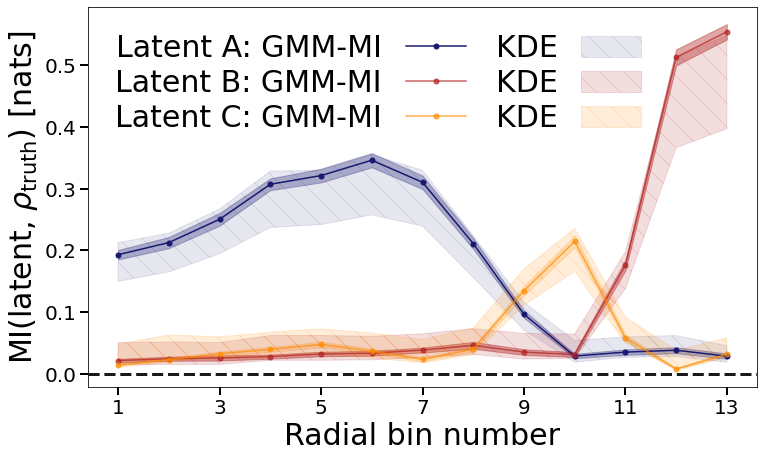

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

MI_radial_mean = all_MI_estimates[:, 0, 0]
MI_radial_std = all_MI_estimates[:, 0, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='midnightblue', marker='o', 
        markersize=5, alpha=1, label='Latent A: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std, 
                MI_radial_mean+MI_radial_std, color='midnightblue', alpha=0.3)

MI_radial_mean = all_MI_estimates[:, 1, 0]
MI_radial_std = all_MI_estimates[:, 1, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='firebrick', marker='o', 
        markersize=5, alpha=0.7, label='Latent B: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std,
                MI_radial_mean+MI_radial_std, color='firebrick', alpha=0.4)

MI_radial_mean = all_MI_estimates[:, 2, 0]
MI_radial_std = all_MI_estimates[:, 2, 1]
ax.plot(np.arange(1, 1+radial_bins), MI_radial_mean, color='darkorange', marker='o', 
        markersize=5, alpha=0.7, label='Latent C: GMM-MI')
ax.fill_between(np.arange(1, 1+radial_bins), MI_radial_mean-MI_radial_std, 
                MI_radial_mean+MI_radial_std, color='darkorange', alpha=0.2)


ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', 
                alpha=0.1, label='KDE', hatch="\\")

ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', 
                alpha=0.15, label='KDE', hatch="\\")

ax.fill_between(np.arange(1, 1+radial_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', 
                alpha=0.15, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False, frameon=False)

# hatches do not show if we save in pdf...
# so we save in png and then convert offline
fig.savefig('./figures/MI_trend_NeurIPS.png', bbox_inches='tight', dpi=600);